<a href="https://colab.research.google.com/github/yonigresearch-wq/ML-workflows/blob/main/simple_NN_for_netflix_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building a Neural Network for classification of netflix competition data

In [ ]:
# Import relevant libraries

import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# Import training data

con = "http://www.tau.ac.il/~saharon/StatsLearn2024-5/train_ratings_all.txt"
X_tr = pd.read_table(con)
con = "http://www.tau.ac.il/~saharon/StatsLearn2024-5/train_y_rating.txt"
y_tr = pd.read_table(con)

# Convert y values from 1-5 to 1-4

y_tr = y_tr.replace(1.0, 0.0)
y_tr = y_tr.replace(2.0, 1.0)
y_tr = y_tr.replace(3.0, 2.0)
y_tr = y_tr.replace(4.0, 3.0)
y_tr = y_tr.replace(5.0, 4.0)

# Convert into numpy arrays

X_tr = X_tr.values
y_tr = y_tr.values


In [ ]:
# Train - Validation split

X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=1)


In [ ]:
# Construct class - Model for nueral network

class Model(nn.Module):
  # input layer (99 movies)
  # 2 hidden layers
  # output layer - classifier (5 classes)

  def __init__(self, in_features=99, h1=10, h2=8, out_features=5):
    super().__init__() # use super since we are using a parent class
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.out(x)

    return out

In [ ]:
model = Model()
model

Model(
  (fc1): Linear(in_features=99, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=5, bias=True)
)

In [ ]:
# Convert data into tensors

X_train = torch.FloatTensor(X_train) # with decimals
X_val = torch.FloatTensor(X_val) # with decimals

y_train = torch.tensor(y_train, dtype=torch.long).squeeze()
y_val = torch.tensor(y_val, dtype=torch.long).squeeze()

In [ ]:
# we will use cross-entropy loss and Adam optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [ ]:
epochs = 1000
losses = []

for epoch in range(epochs):
  # run data through forward and obtain prediction
  y_pred = model(X_train)
  # calculate loss
  loss = criterion(y_pred, y_train)
  # track losses
  losses.append(loss.item())

  if epoch % 10 == 0:
    print(f'Epoch: {epoch}, Loss = {loss}')

  # apply back-propogation and update parameters
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0, Loss = 1.5896834135055542
Epoch: 10, Loss = 1.3474023342132568
Epoch: 20, Loss = 1.2806490659713745
Epoch: 30, Loss = 1.2402712106704712
Epoch: 40, Loss = 1.2083895206451416
Epoch: 50, Loss = 1.1893337965011597
Epoch: 60, Loss = 1.1811504364013672
Epoch: 70, Loss = 1.173326849937439
Epoch: 80, Loss = 1.1680259704589844
Epoch: 90, Loss = 1.1624096632003784
Epoch: 100, Loss = 1.1592326164245605
Epoch: 110, Loss = 1.1545175313949585
Epoch: 120, Loss = 1.1543103456497192
Epoch: 130, Loss = 1.1532355546951294
Epoch: 140, Loss = 1.1514886617660522
Epoch: 150, Loss = 1.1511794328689575
Epoch: 160, Loss = 1.1494724750518799
Epoch: 170, Loss = 1.1464577913284302
Epoch: 180, Loss = 1.1415904760360718
Epoch: 190, Loss = 1.138180136680603
Epoch: 200, Loss = 1.1380583047866821
Epoch: 210, Loss = 1.1576290130615234
Epoch: 220, Loss = 1.1368141174316406
Epoch: 230, Loss = 1.1361359357833862
Epoch: 240, Loss = 1.1350518465042114
Epoch: 250, Loss = 1.1374578475952148
Epoch: 260, Loss = 1.1307

Text(0.5, 0, 'epoch')

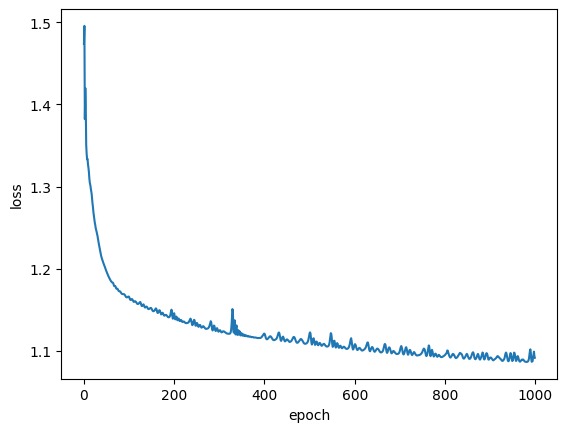

In [ ]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error as MSE

# Use softmax to calculate class rating probs
# Calculate weighted mean

logits = model(X_train)
probs = torch.softmax(logits, dim=1)
class_ids = torch.arange(probs.shape[1], device=probs.device)
y_pred_train = (probs * class_ids).sum(dim=1).detach().cpu().numpy()

train_error = np.sqrt(MSE(y_pred_train, y_train))
print(f'Training error: {train_error}')

logits = model(X_val)
probs = torch.softmax(logits, dim=1)
class_ids = torch.arange(probs.shape[1], device=probs.device)
y_pred_val = (probs * class_ids).sum(dim=1).detach().cpu().numpy()

val_error = np.sqrt(MSE(y_pred_val, y_val))
print(f'Validation error: {val_error}')

Training error: 0.769395535502559
Validation error: 0.7558054744615063


In [ ]:
# tuning hidden layer dimension
# using rMSE loss

hidden_layer_size = [3, 4, 5, 6, 7, 8, 9, 10]

for layer_size in hidden_layer_size:

  epochs = 500
  losses = []

  model = Model(hidden_layer_size=layer_size)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  for epoch in range(epochs):

    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  y_pred_train = model(X_train).argmax(dim=1).detach().numpy()
  train_error = np.sqrt(MSE(y_pred_train, y_train))
  print(f'Training error with hidden layer size = {layer_size:.3f}: {train_error:.3f}')

  y_pred_val = model(X_val).argmax(dim=1).detach().numpy()
  val_error = np.sqrt(MSE(y_pred_val, y_val))
  print(f'Validation error with hidden layer size = {layer_size:.3f}: {val_error:.3f}')




Training error with hidden layer size = 3.000: 0.836
Validation error with hidden layer size = 3.000: 0.827
Training error with hidden layer size = 4.000: 0.837
Validation error with hidden layer size = 4.000: 0.819
Training error with hidden layer size = 5.000: 0.831
Validation error with hidden layer size = 5.000: 0.831
Training error with hidden layer size = 6.000: 1.039
Validation error with hidden layer size = 6.000: 1.002
Training error with hidden layer size = 7.000: 0.841
Validation error with hidden layer size = 7.000: 0.830
Training error with hidden layer size = 8.000: 0.836
Validation error with hidden layer size = 8.000: 0.826
Training error with hidden layer size = 9.000: 0.838
Validation error with hidden layer size = 9.000: 0.849
Training error with hidden layer size = 10.000: 0.841
Validation error with hidden layer size = 10.000: 0.832
